#### 가상의 데이터 생성 코드

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import expon

# Set random seed for reproducibility
np.random.seed(42)

# Generate user data
num_users = 50000
user_ids = range(1, num_users + 1)

# Assign test groups
test_groups = np.random.choice(['control', 'test'], size=num_users, p=[0.5, 0.5])

# Assign age groups
age_groups = np.random.choice(['10s', '20s', '30s', '40s'], size=num_users, p=[0.15, 0.35, 0.35, 0.15])

# Create user info dataframe
user_info_df = pd.DataFrame({
    'user_id': user_ids,
    'test_group': test_groups,
    'age_group': age_groups
})

# Generate views and clicks
views = expon.rvs(scale=1000, size=num_users).astype(int)
views = np.clip(views, 0, 10000)

# Generate base CTR
base_ctr = expon.rvs(scale=0.05, size=num_users)
base_ctr = np.clip(base_ctr, 0, 1)

# Adjust CTR based on test group and age group
ctr_adjustment = np.ones(num_users)
ctr_adjustment[test_groups == 'test'] *= 1.25  # 25% uplift for test group

# Additional uplift for 20s and 30s in test group
ctr_adjustment[(test_groups == 'test') & (age_groups == '20s')] *= 1.1
ctr_adjustment[(test_groups == 'test') & (age_groups == '30s')] *= 1.1

adjusted_ctr = base_ctr * ctr_adjustment
adjusted_ctr = np.clip(adjusted_ctr, 0, 1)

# Calculate clicks based on views and adjusted CTR
clicks = (views * adjusted_ctr).astype(int)
clicks = np.clip(clicks, 0, 5000)

# Create AB test results dataframe
ab_test_df = pd.DataFrame({
    'user_id': user_ids,
    'views': views,
    'clicks': clicks
})

# Save dataframes to CSV
user_info_df.to_csv('/content/drive/MyDrive/데이터셋/user_info_data.csv', index=False)
ab_test_df.to_csv('/content/drive/MyDrive/데이터셋/ab_test_data.csv', index=False)

#### A/B 테스트 분석

##### 데이터 이해하기 & 데이터 전처리

In [32]:
import pandas as pd

In [33]:
user_info = pd.read_csv('/content/drive/MyDrive/데이터셋/user_info_data.csv')
ab_test_results = pd.read_csv('/content/drive/MyDrive/데이터셋/ab_test_data.csv')

In [34]:
user_info.head()

,user_id,test_group,age_group
0,1,control,30s
1,2,test,20s
2,3,test,20s
3,4,test,30s
4,5,control,20s


In [35]:
ab_test_results.head()

,user_id,views,clicks
0,1,869,3
1,2,748,45
2,3,432,47
3,4,679,67
4,5,454,41


In [36]:
data = pd.merge(user_info, ab_test_results, on='user_id')
data.head()

,user_id,test_group,age_group,views,clicks
0,1,control,30s,869,3
1,2,test,20s,748,45
2,3,test,20s,432,47
3,4,test,30s,679,67
4,5,control,20s,454,41


In [37]:
data['ctr'] = data['clicks'] / data['views']
data.head()

,user_id,test_group,age_group,views,clicks,ctr
0,1,control,30s,869,3,0.003452
1,2,test,20s,748,45,0.060160
2,3,test,20s,432,47,0.108796
3,4,test,30s,679,67,0.098675
4,5,control,20s,454,41,0.090308


##### 문제 정의

* 프로덕트: 이커머스 상품 리스트 페이지
* 테스트할 새로운 기능: 상품 이미지에 태그 (베스트, 신상품, 세일 등)


* control 그룹: 기존안 (상품 이미지 태그 미포함)
* test 그룹: 개선안 (상품 이미지 태그 포함)

<img src='https://www.abtasty.com/wp-content/uploads/2018/06/sorting-product-listing-page-768x637.jpg' width = "500" height = "400"/>

* 목표 지표: CTR (상품클릭수 / 상품조회수)
* 가드레일 지표: 상품조회수

분석해볼 내용
1. control군과 test군의 목표 지표에 유의미한 차이가 있었는가?
2. control군과 test군의 가드레일 지표가 차이가 있는가? 떨어지지 않았는가?
3. 지표들에 연령대별 차이가 있는지 추가 분석


##### 분석 및 시각화

1. control군과 test군의 목표 지표에 유의미한 차이가 있었는가?

In [38]:
data.head()

,user_id,test_group,age_group,views,clicks,ctr
0,1,control,30s,869,3,0.003452
1,2,test,20s,748,45,0.060160
2,3,test,20s,432,47,0.108796
3,4,test,30s,679,67,0.098675
4,5,control,20s,454,41,0.090308


In [39]:
data.groupby('test_group')['ctr'].mean()

,ctr
test_group,
control,0.04784
test,0.06475


In [40]:
test_ctr = data.query('test_group == "test"')['ctr'].mean()
control_ctr = data.query('test_group == "control"')['ctr'].mean()

print(f'test_ctr: {test_ctr:.2%}')
print(f'control_ctr: {control_ctr:.2%}')
print(f'uplift%: {test_ctr/control_ctr - 1:.2%}')

test_ctr: 6.47%
control_ctr: 4.78%
uplift%: 35.35%


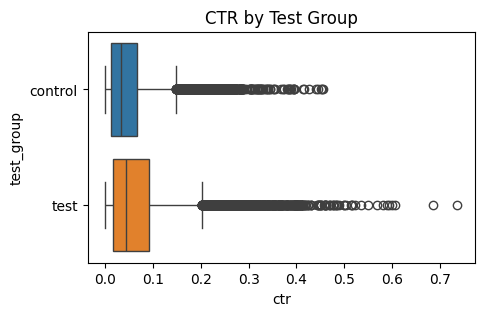

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(5,3))
sns.boxplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')
plt.show()

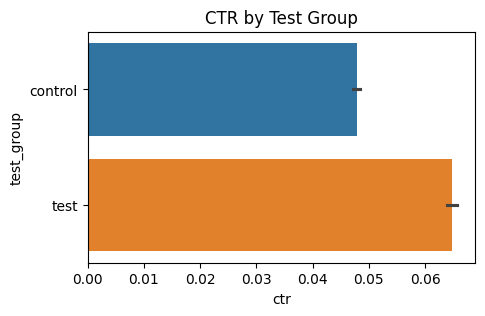

In [42]:
plt.figure(figsize=(5,3))
sns.barplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')
plt.show()

2. control군과 test군의 가드레일 지표가 차이가 있는가? 떨어지지 않았는가?

In [43]:
data.groupby('test_group')['views'].mean()

,views
test_group,
control,999.176506
test,1011.922917


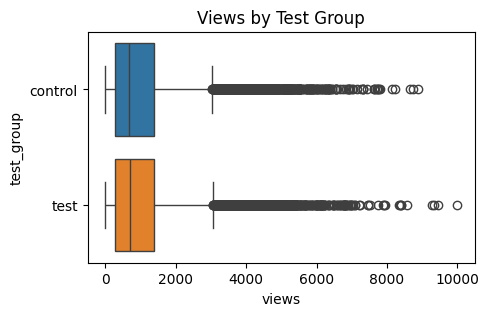

In [44]:
plt.figure(figsize=(5,3))
sns.boxplot(y='test_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')
plt.show()

In [45]:
data.groupby('test_group')[['views','clicks','ctr']].mean()

,views,clicks,ctr
test_group,,,
control,999.176506,49.242207,0.04784
test,1011.922917,67.510562,0.06475


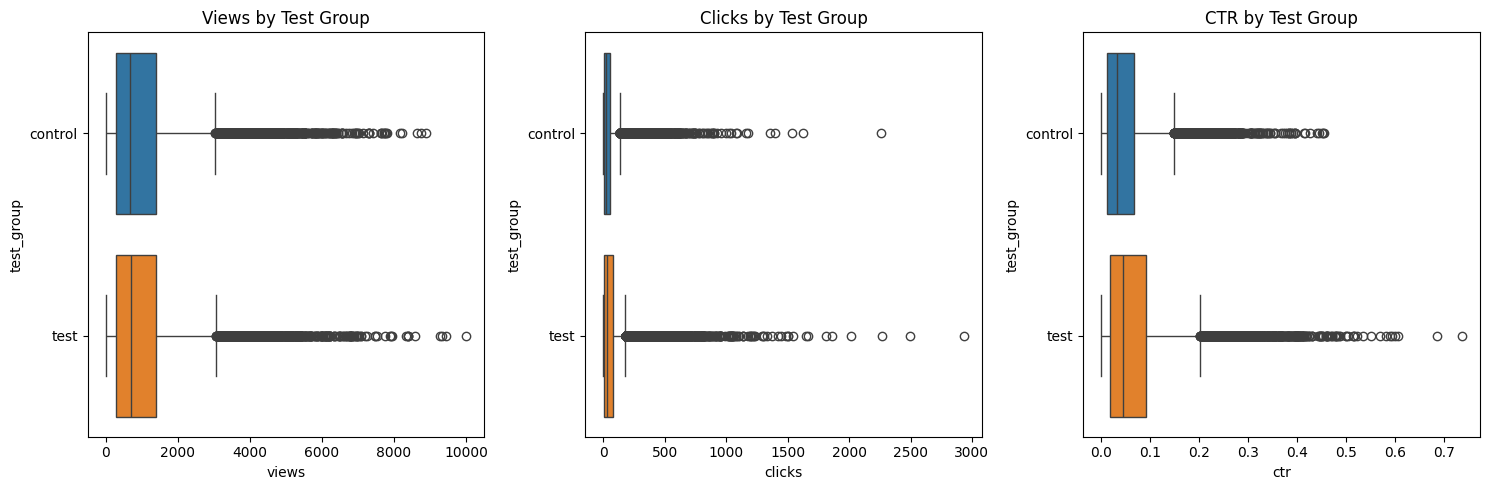

In [46]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(y='test_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.boxplot(y='test_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.boxplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

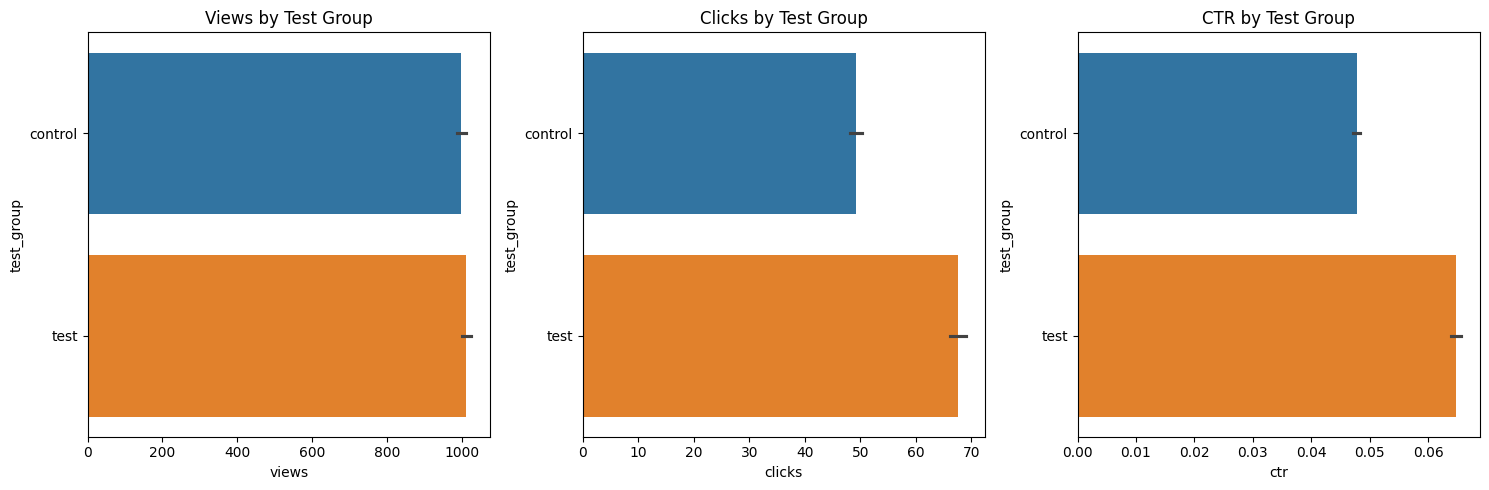

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(y='test_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.barplot(y='test_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.barplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

3. 지표들에 연령대별 차이가 있는지 추가 분석

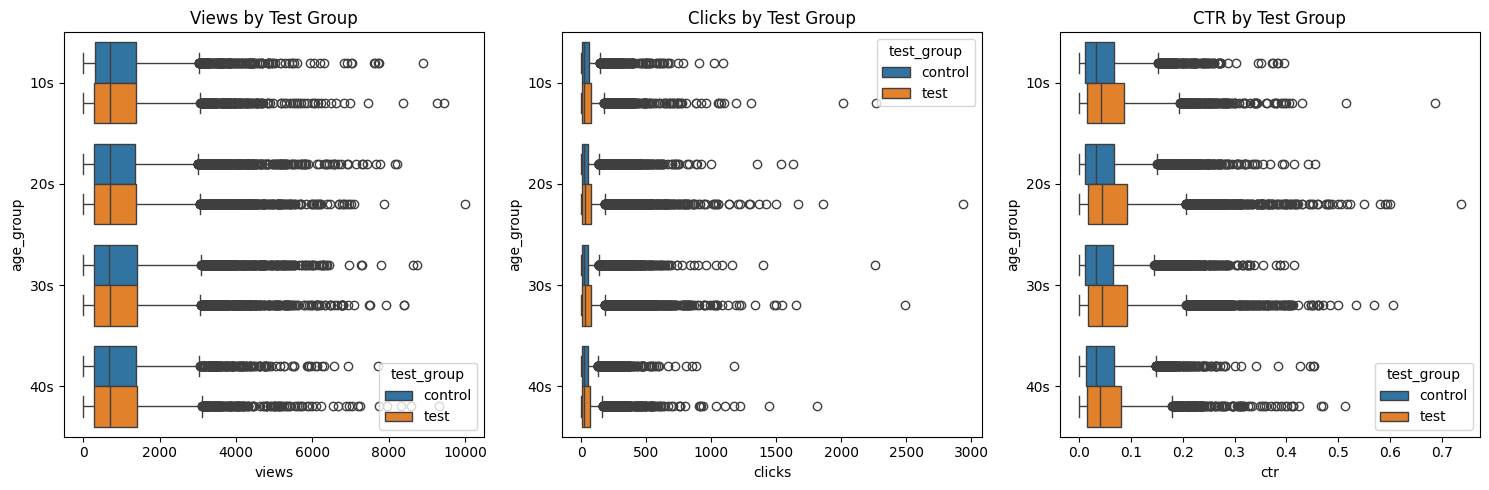

In [49]:
data.sort_values(['age_group','test_group'], inplace=True)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(y='age_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.boxplot(y='age_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.boxplot(y='age_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

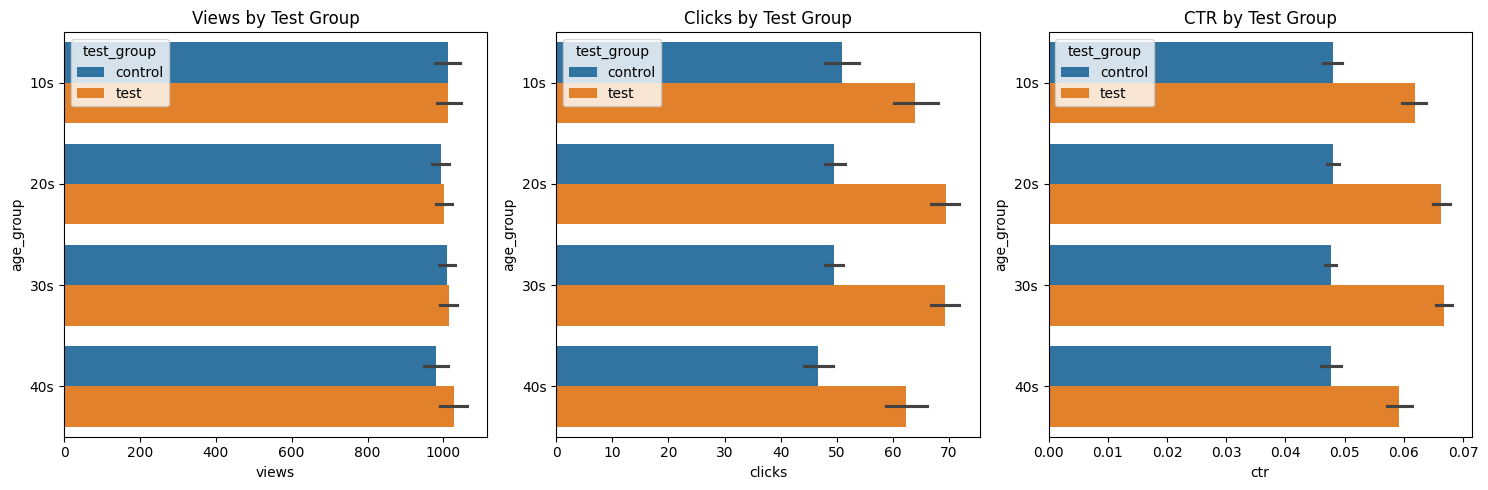

In [50]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(y='age_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.barplot(y='age_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.barplot(y='age_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

##### 통계 검정

In [54]:
from scipy import stats

In [61]:
for index in ['views', 'clicks', 'ctr']:
    print(f'--- {index} ---')

    if index == 'ctr':
        data_copy = data.copy().query('views > 0')
    else:
        data_copy = data.copy()

    control = data_copy.query('test_group == "control"')[index]
    test = data_copy.query('test_group == "test"')[index]
    uplift = test.mean() / control.mean() - 1
    print(f'test group mean: {test.mean():.2f}')
    print(f'control group mean: {control.mean():.2f}')
    print(f'uplift: {uplift:.2%}')

    statistics, p_value = stats.ttest_ind(control, test, alternative='two-sided')
    print(f't test p-value: {p_value:.4f}')

    if p_value < 0.05:
        print(f'Reject the null hypothesis for {index}.')
        print('Significant difference between control and test groups.')
    else:
        print(f'Fail to reject the null hypothesis for {index}.')
        print('No significant difference between control and test groups.')
    print()

--- views ---
test group mean: 1011.92
control group mean: 999.18
uplift: 1.28%
t test p-value: 0.1556
Fail to reject the null hypothesis for views.
No significant difference between control and test groups.

--- clicks ---
test group mean: 67.51
control group mean: 49.24
uplift: 37.10%
t test p-value: 0.0000
Reject the null hypothesis for clicks.
Significant difference between control and test groups.

--- ctr ---
test group mean: 0.06
control group mean: 0.05
uplift: 35.35%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.



In [62]:
for age_group in ['10s', '20s', '30s', '40s']:
    print(f'--- {age_group} ---')
    for index in ['views', 'clicks', 'ctr']:
        print(f'--- {index} ---')

        if index == 'ctr':
            data_copy = data.copy().query(f'views > 0 and age_group == "{age_group}"')
        else:
            data_copy = data.copy().query(f'age_group == "{age_group}"')

        control = data_copy.query('test_group == "control"')[index]
        test = data_copy.query('test_group == "test"')[index]
        uplift = test.mean() / control.mean() - 1
        print(f'test group mean: {test.mean():.2f}')
        print(f'control group mean: {control.mean():.2f}')
        print(f'uplift: {uplift:.2%}')

        statistics, p_value = stats.ttest_ind(control, test, alternative='two-sided')
        print(f't test p-value: {p_value:.4f}')

        if p_value < 0.05:
            print(f'Reject the null hypothesis for {index}.')
            print('Significant difference between control and test groups.')
        else:
            print(f'Fail to reject the null hypothesis for {index}.')
            print('No significant difference between control and test groups.')
        print()
    print()

--- 10s ---
--- views ---
test group mean: 1012.05
control group mean: 1011.04
uplift: 0.10%
t test p-value: 0.9660
Fail to reject the null hypothesis for views.
No significant difference between control and test groups.

--- clicks ---
test group mean: 63.98
control group mean: 50.87
uplift: 25.77%
t test p-value: 0.0000
Reject the null hypothesis for clicks.
Significant difference between control and test groups.

--- ctr ---
test group mean: 0.06
control group mean: 0.05
uplift: 28.72%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.


--- 20s ---
--- views ---
test group mean: 1002.22
control group mean: 993.02
uplift: 0.93%
t test p-value: 0.5414
Fail to reject the null hypothesis for views.
No significant difference between control and test groups.

--- clicks ---
test group mean: 69.38
control group mean: 49.51
uplift: 40.13%
t test p-value: 0.0000
Reject the null hypothesis for clicks.
Significant difference betw

In [63]:
data.to_csv('./data.csv', index=False)